In [2]:
import os
import numpy as np


import nibabel as nib


import gudhi


import matplotlib.pyplot as plt


from persim import plot_diagrams
from ripser import ripser, lower_star_img


data_folders = [
    "nifti/0/",
    "nifti/1/",
    "nifti/2/",
    "nifti/masks/"]

file_names = []
for df in data_folders:
    file_names.append(sorted(os.listdir(df)))

def find_extreme_values(i):
    min_value = 5000
    max_value = -5000
    j = 0
    df = data_folders[i]
    for fn in file_names[i]:
        j += 1
        file_path = os.path.join(df, fn)
        img_nifti = nib.load(file_path)
        img_np = np.array(img_nifti.dataobj)
        img_values = np.array(list(set(img_np.flatten())))
        img_min = img_values.min()
        img_max = img_values.max()
        min_value = min(min_value, img_min)
        max_value = max(max_value, img_max)
        if j % 10 == 0:
            print(j)

    print(min_value, max_value)


def find_border(image):
    values = np.array(list(set(image.flatten())))
    a, b = values.min(), values.max()
    print(a, b)
    return a, b

def img_read(file_path):
    img = nib.load(file_path)
    return np.array(img.dataobj).astype(int)

def my_rescale(image_old, low_new=0.0, high_new=1.0):
    low_old, high_old = np.sort(list(set(image_old.flatten())))[[0, -1]]
    range_new = high_new - low_new
    range_old = high_old - low_old
    factor = range_new / range_old
    image_new = (image_old.astype(float) - low_old) * factor + low_new
    return image_new



In [3]:
import imageio
import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np # linear algebra
import pandas as pd # reading and processing of tables
import skimage, os
from skimage.morphology import convex_hull_image
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage.util import montage as montage2d
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
# import dicom
import scipy.misc
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
CT_OFFSET = 1024
ZERO_VALUE = 0

In [4]:
def show_file(i, j=0, file_name=None):
    if file_name:
        file_path_00 = os.path.join(data_folders[i], file_name)
    else:
        file_path_00 = os.path.join(data_folders[i], file_names[i][j])
    img_00_raw = img_read(file_path_00)
    img_00 = my_rescale(img_00_raw)
    for i in range(img_00.shape[-1]):
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.imshow(img_00_raw[:, :, i])
        plt.colorbar()
        minv, maxv = np.sort(list(set(img_00_raw[:, :, i].flatten())))[[0, -1]]
        plt.title('Slice #{} (from {} to {})'.format(i + 1, minv, maxv))
        plt.subplot(122)
        plt.imshow(img_00[:, :, i])
        plt.colorbar()
        plt.title('Slice #{} (from 0.0 to 1.0)'.format(i + 1))
        plt.show()
    return img_00

def get_segmented_lungs(in_im, plot=False, convex_hull=False):
    im = in_im.copy() # don't change the input
    '''
    This funtion segments the lungs from the given 2D slice.
    '''
    if plot == True:
        f, plots = plt.subplots(3, 3, figsize=(10, 10))
        plots = plots.flatten()
    '''
    Step 1: Convert into a binary image. 
    '''
    binary = im < 0.7
    if plot == True:
        plots[0].axis('off')
        plots[0].imshow(binary, cmap=plt.cm.bone) 
        plots[0].set_title('First Threshold')
    '''
    Step 2: Remove the blobs connected to the border of the image.
    '''
    cleared = clear_border(binary)
    if plot == True:
        plots[1].axis('off')
        plots[1].imshow(cleared, cmap=plt.cm.bone) 
        plots[1].set_title('Remove Border')
    '''
    Step 3: Label the image.
    '''
    label_image = label(cleared)
    if plot == True:
        plots[2].axis('off')
        plots[2].imshow(label_image, cmap=plt.cm.gist_earth)
        plots[2].set_title('Label Components')
    '''
    Step 4: Keep the labels with 2 largest areas.
    '''
    areas = [r.area for r in regionprops(label_image)]
    areas.sort()
    if len(areas) > 2:
        for region in regionprops(label_image):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       label_image[coordinates[0], coordinates[1]] = 0
    binary = label_image > 0
    if plot == True:
        plots[3].axis('off')
        plots[3].imshow(binary, cmap=plt.cm.bone) 
        plots[3].set_title('Keep Biggest 2')
    '''
    Step 5: Erosion operation with a disk of radius 2. This operation is 
    seperate the lung nodules attached to the blood vessels.
    '''
    selem = disk(2)
    binary = binary_erosion(binary, selem)
    if plot == True:
        plots[4].axis('off')
        plots[4].imshow(binary, cmap=plt.cm.bone)
        plots[4].set_title('Erosion')
    '''
    Step 6: Closure operation with a disk of radius 10. This operation is 
    to keep nodules attached to the lung wall.
    '''
    selem = disk(10)
    binary = binary_closing(binary, selem)
    if plot == True:
        plots[5].axis('off')
        plots[5].imshow(binary, cmap=plt.cm.bone) 
        plots[5].set_title('Close Image')
    '''
    Step 7: Fill in the small holes inside the binary mask of lungs.
    '''
    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    if plot == True:
        plots[6].axis('off')
        plots[6].imshow(binary, cmap=plt.cm.bone) 
        plots[6].set_title('Fill holes')
    '''
    Step 8: Superimpose the binary mask on the input image.
    '''
    if convex_hull:
        binary = convex_hull_image(binary)
    get_high_vals = (binary == 0)
    im[get_high_vals] = ZERO_VALUE # minimum value
    if plot == True:
        plots[7].axis('off')
        plots[7].imshow(im, cmap=plt.cm.bone) 
        plots[7].set_title('Binary Masked Input')
        
    return im
def postprocess(x):
    x = x.copy()
    new_arr = x / np.percentile(x, 99)
    new_arr[new_arr > 1] = 1
    new_arr = 1 - (1 / (1 - np.percentile(new_arr, 1))) * (1 - new_arr)
    return new_arr

In [5]:
from lungmask import mask
import SimpleITK as sitk

In [6]:
import cv2
def show_masks_overlayed(j):
    shape = img_read(os.path.join(data_folders[1], file_names[1][j])).shape
    img = my_rescale(img_read(os.path.join(data_folders[1], file_names[1][j])))
    for t in np.arange(2, shape[2] - 3):
        file_path_img = 'datamasks/imgs/img_{}_{}.png'.format(j, t)
        file_path_mask = 'datamasks/masks/img_{}_{}.png'.format(j, t)
        
        im = cv2.imread(file_path_img, cv2.IMREAD_GRAYSCALE)
        if type(im) == type(None):
            continue
        plt.figure(figsize=(15, 10))
        masked = cv2.imread(file_path_mask, cv2.IMREAD_GRAYSCALE)
        plt.subplot(131)
        plt.imshow(im, 'gray', interpolation='none')
        plt.subplot(132)
        plt.imshow(im, 'gray', interpolation='none')
        plt.imshow(masked, 'jet', interpolation='none', alpha=0.1)
        plt.subplot(133)
        masked_lung = np.array(im > 0)
        plt.imshow(img[:,:,t], 'gray', interpolation='none')

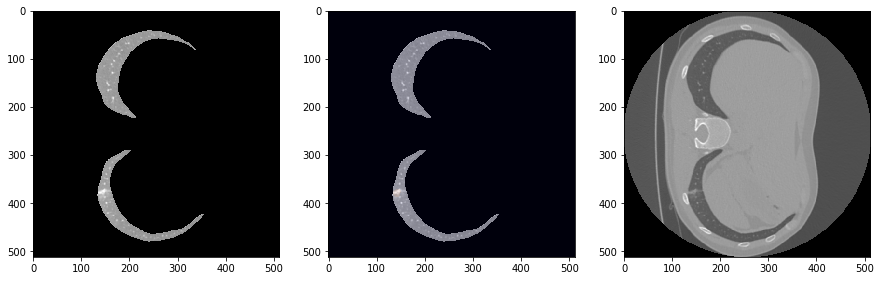

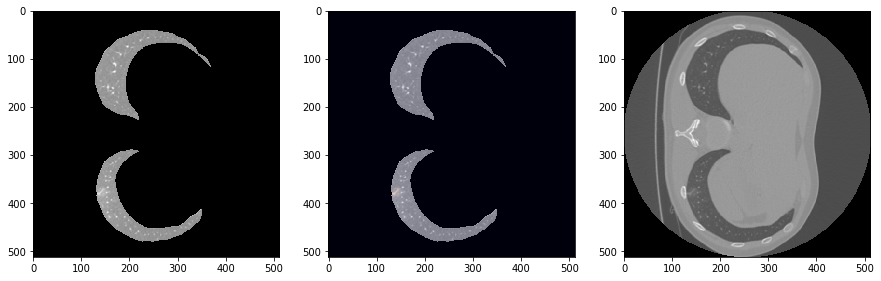

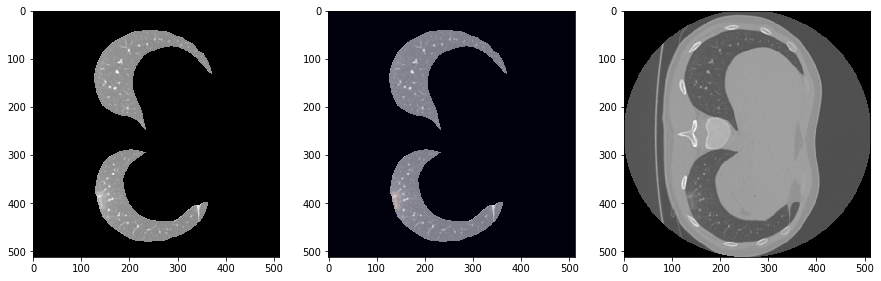

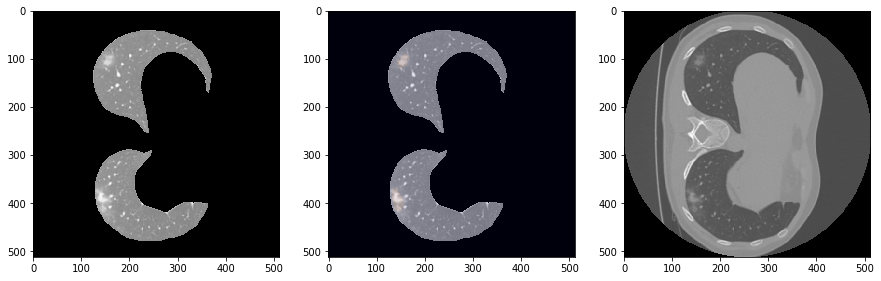

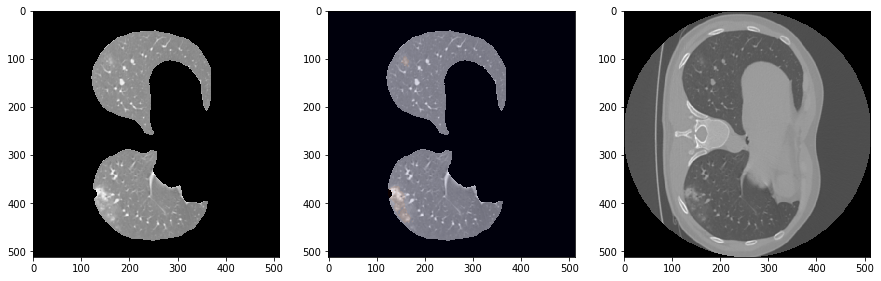

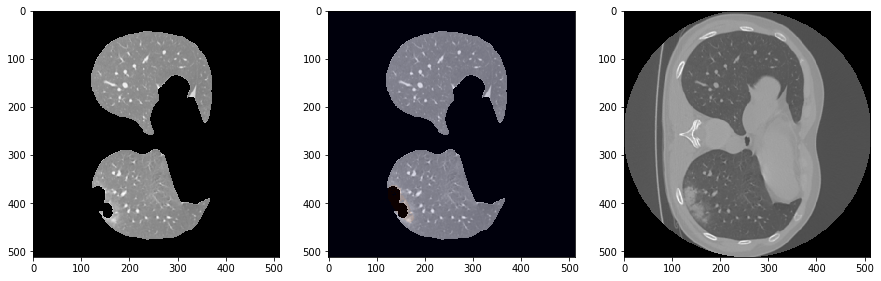

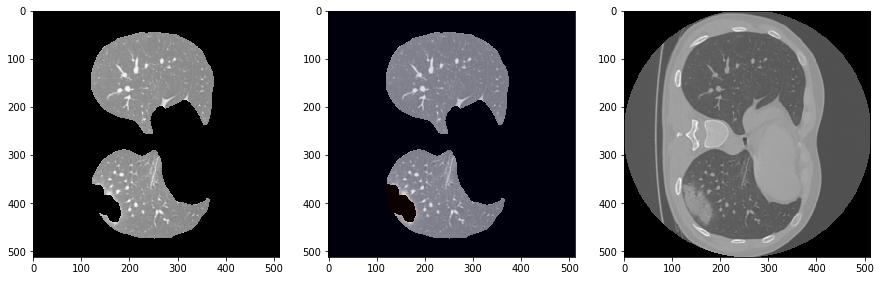

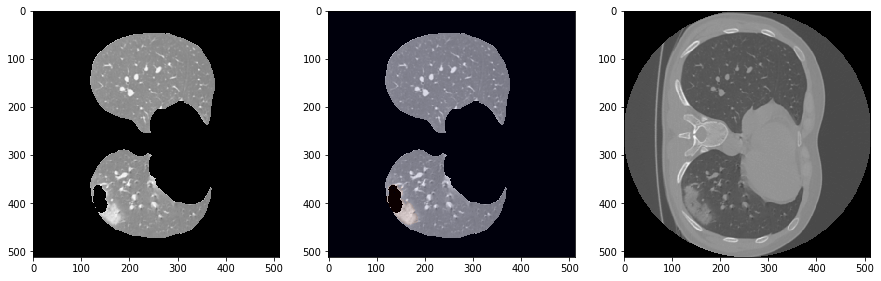

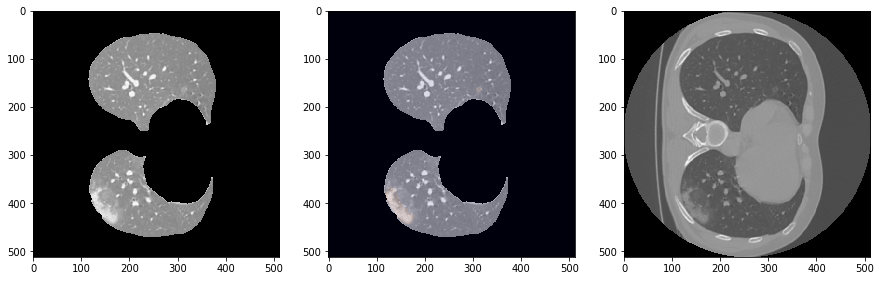

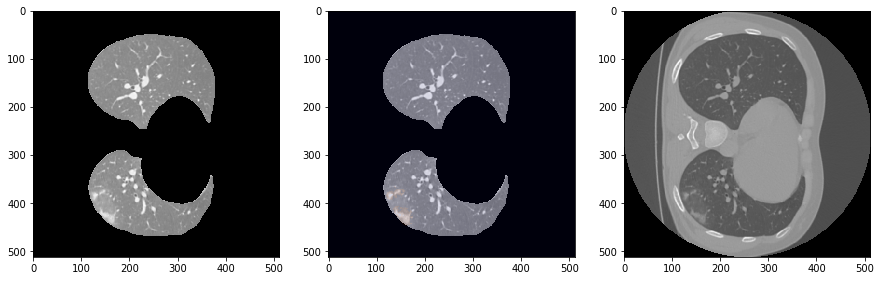

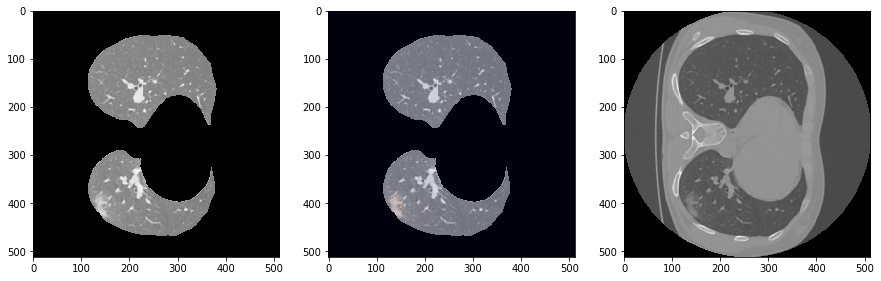

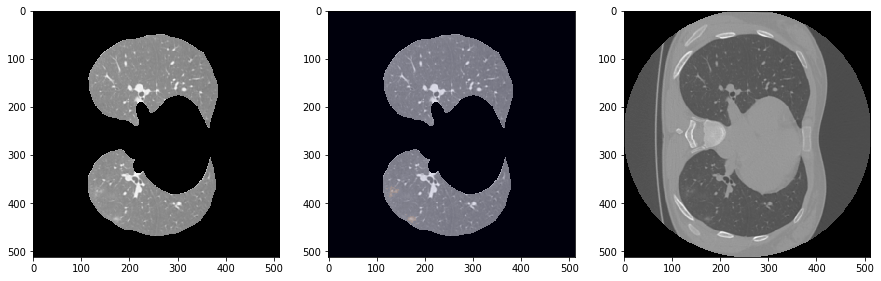

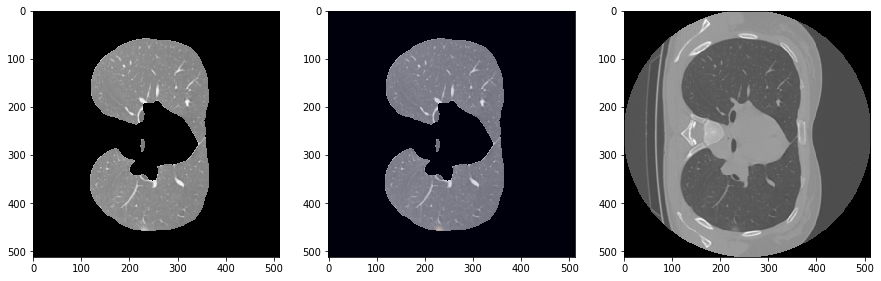

In [6]:
show_masks_overlayed(35)

In [6]:
from os import listdir
from os.path import isfile, join
mypath = 'results/2/'
datafiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
files_2 = list(set([x.split('_')[1] for x in datafiles]))

In [7]:
msk = cv2.imread('results/2/study_1030_23.png', cv2.IMREAD_GRAYSCALE)

In [8]:
def show_masks(i, j):
    mypath = 'data/{}/'.format(str(i))
    i_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    i_files = list(set([x.split('_')[1] for x in i_files]))
    j = i_files[j]
    file_name = [x for x in file_names[i] if 'study_{}'.format(j) in x][0]
    shape = img_read(os.path.join(data_folders[i], file_name)).shape
    img = my_rescale(img_read(os.path.join(data_folders[i], file_name)))
    datafiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'study_{}'.format(j) in f]
    mypath = 'results/{}/'.format(str(i))
    maskfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'study_{}'.format(j) in f]

    for datafile, maskfile in zip(datafiles, maskfiles):
        im = cv2.imread('data/{}/'.format(str(i)) + datafile, cv2.IMREAD_GRAYSCALE)
        if type(im) == type(None):
            continue
        msk = cv2.imread('results/{}/'.format(str(i)) + maskfile, cv2.IMREAD_GRAYSCALE)
        plt.figure(figsize=(15, 10))
        plt.subplot(131)
        plt.imshow(im, 'gray', interpolation='none')
        plt.subplot(132)
        msk = msk > 0
        msk = binary_dilation(msk, disk(25, dtype=bool))
        plt.imshow(im, 'gray', interpolation='none')
        plt.imshow(msk, 'jet', interpolation='none', alpha=0.1)
        plt.subplot(133)
        t = int(datafile[:-4].split('_')[-1])
        plt.imshow(img[:,:,t], 'gray', interpolation='none')

<ipython-input-8-63996e808dd5>:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(15, 10))


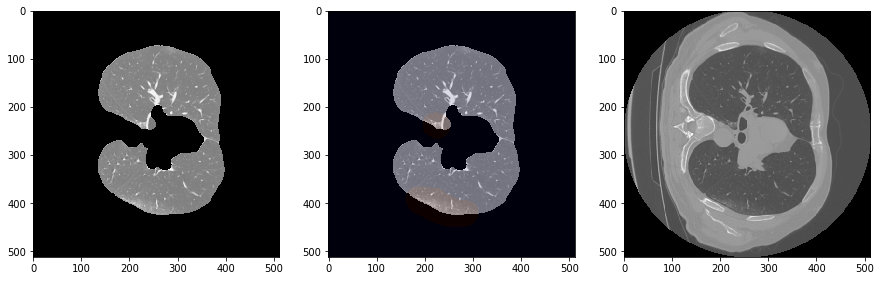

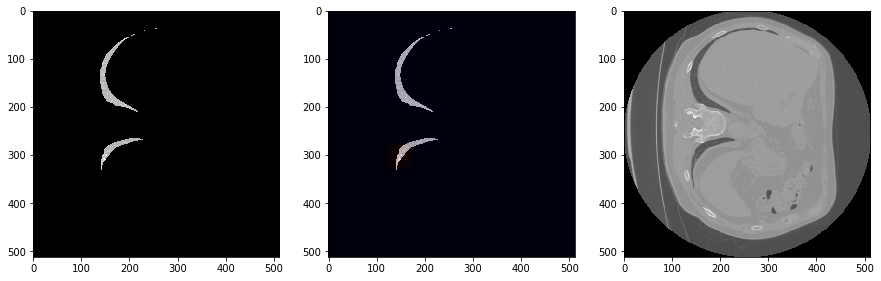

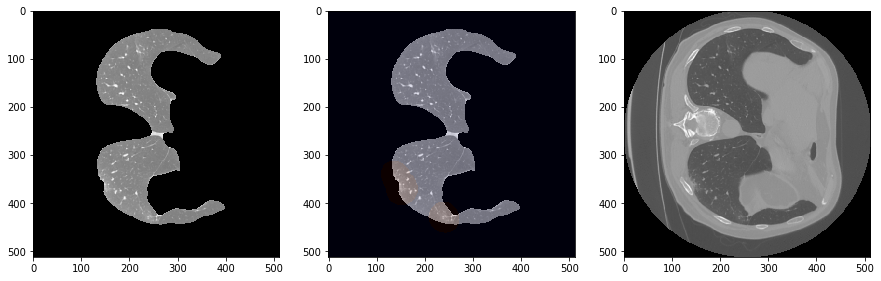

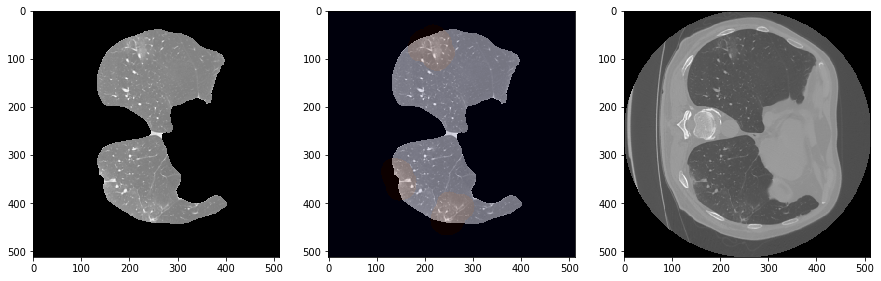

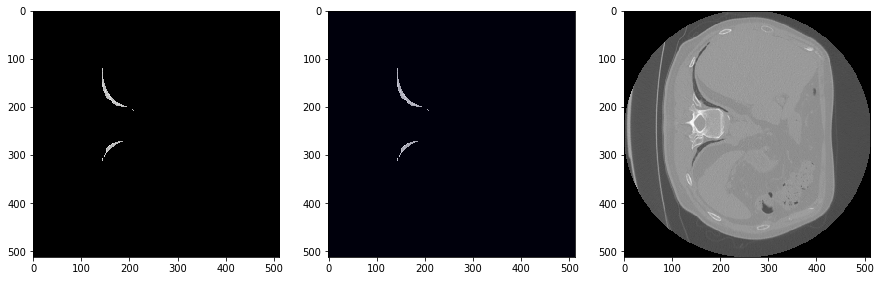

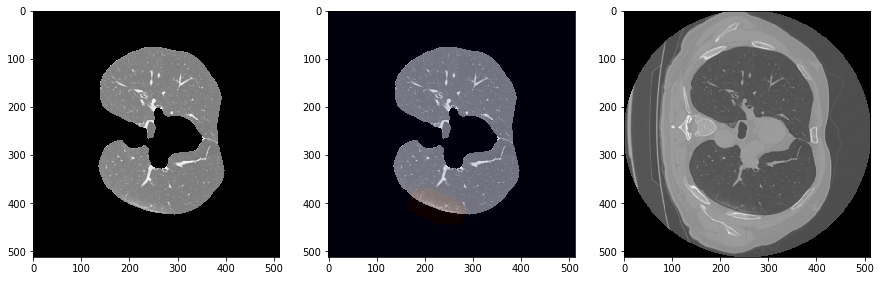

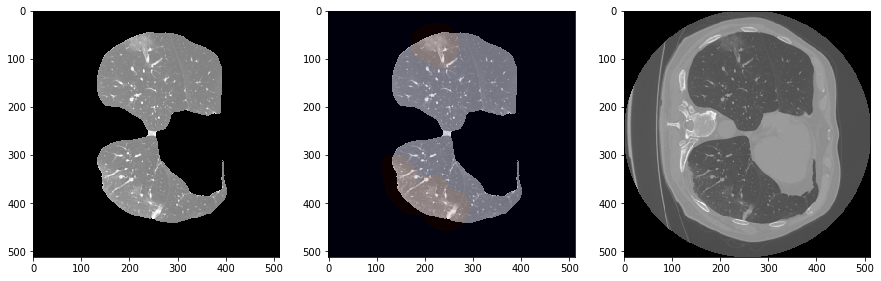

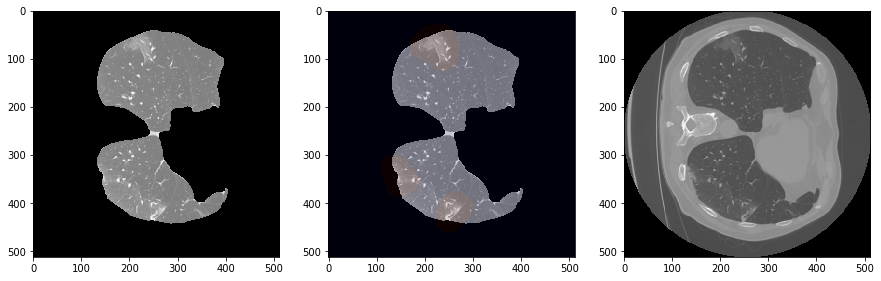

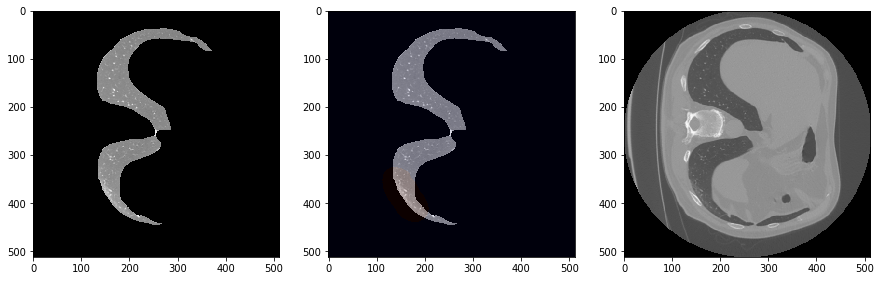

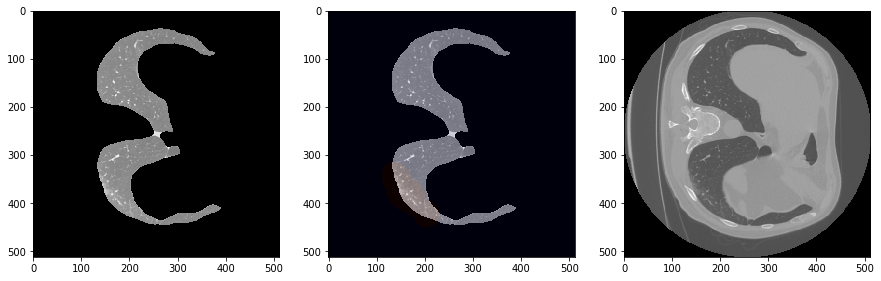

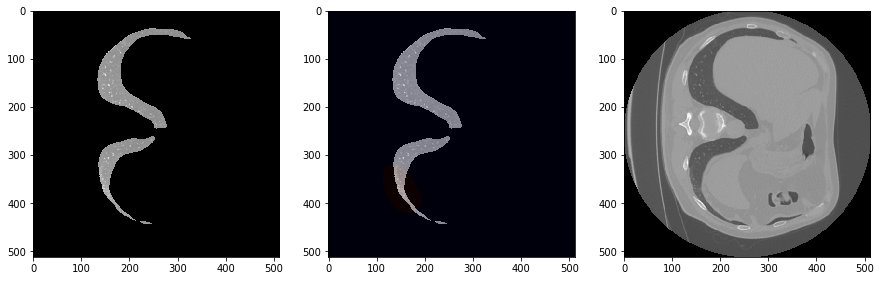

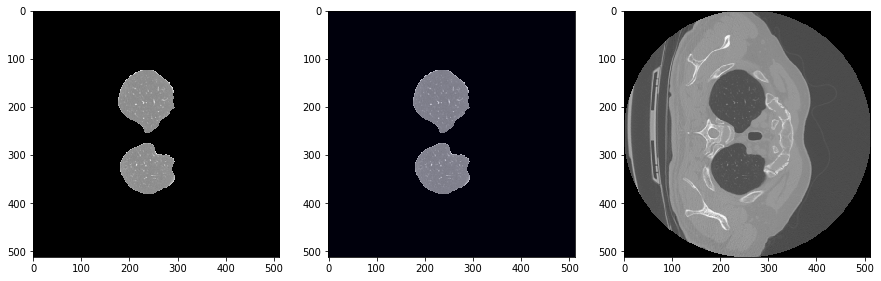

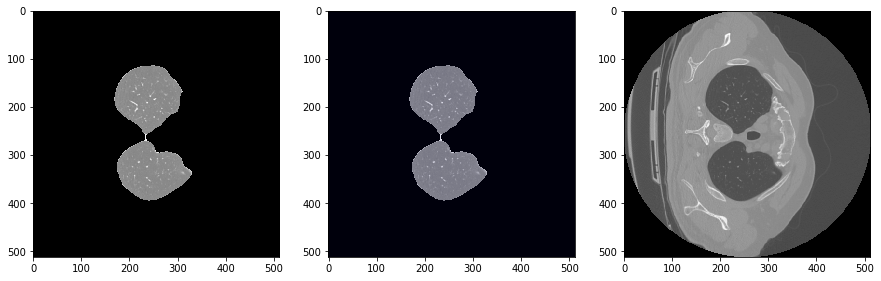

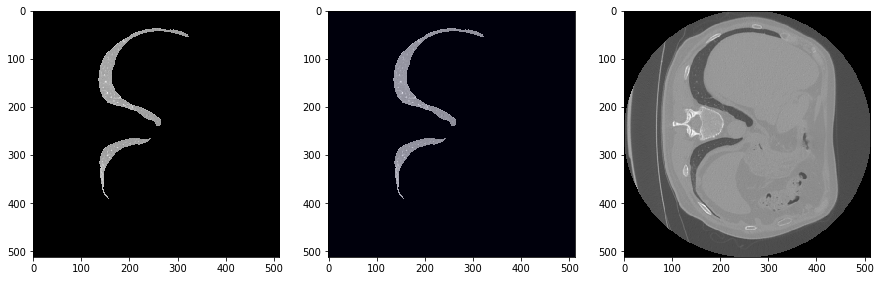

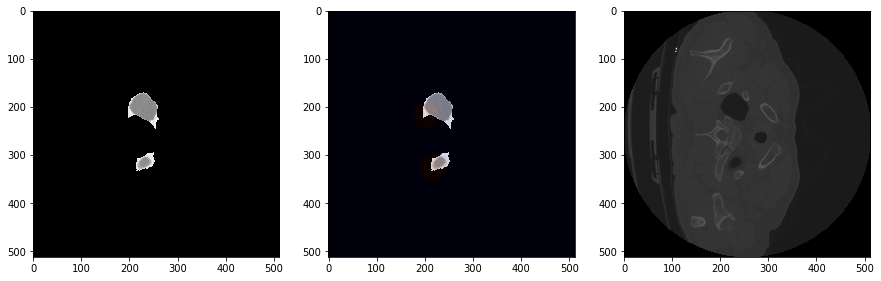

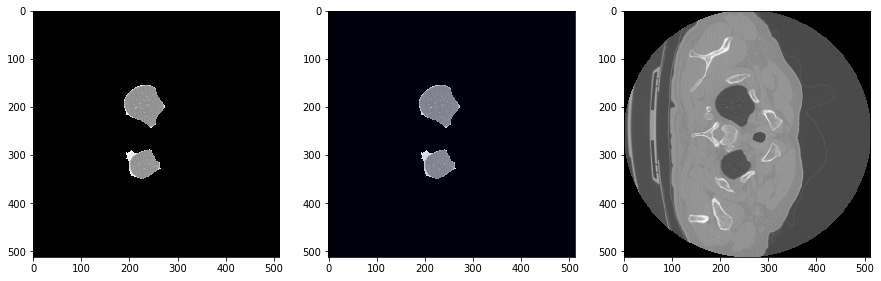

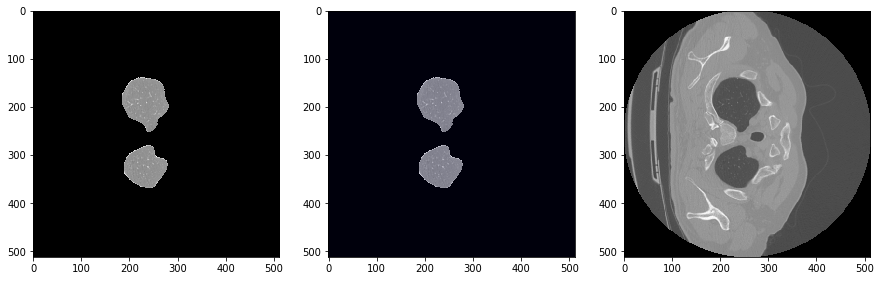

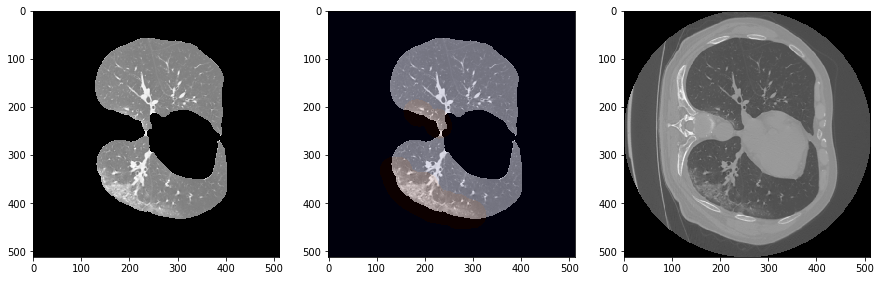

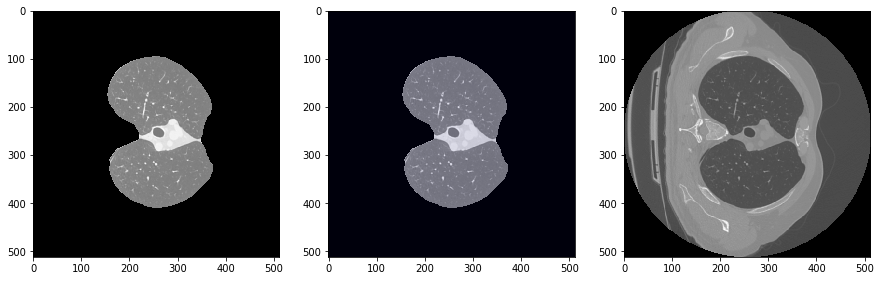

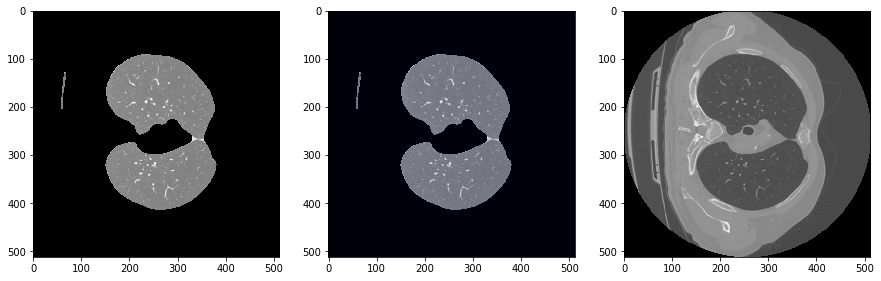

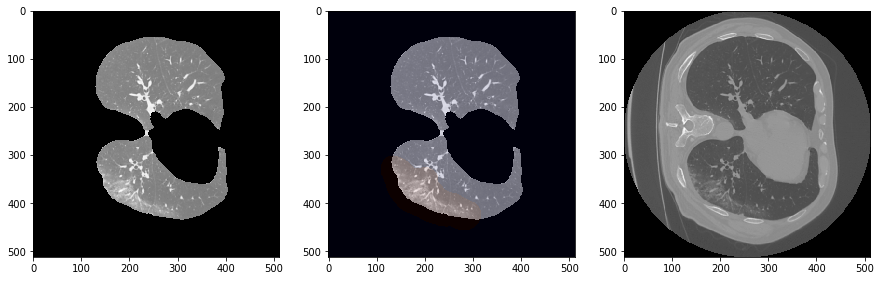

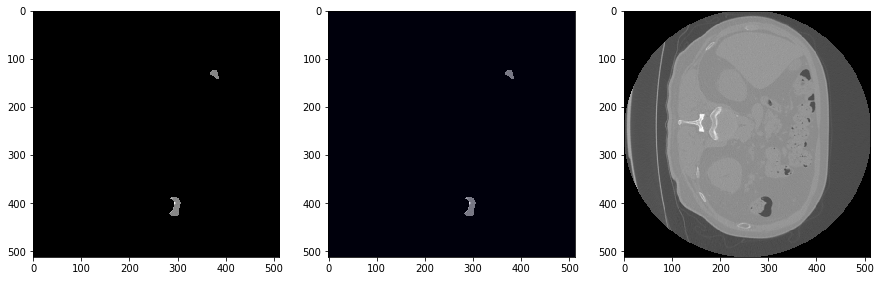

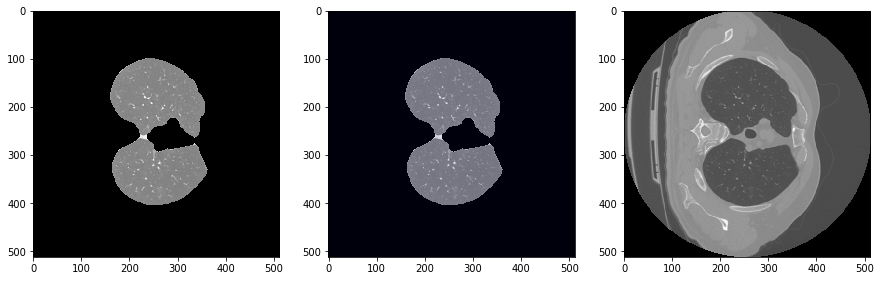

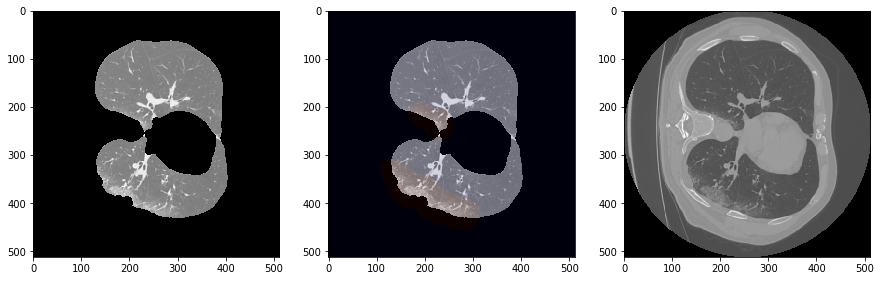

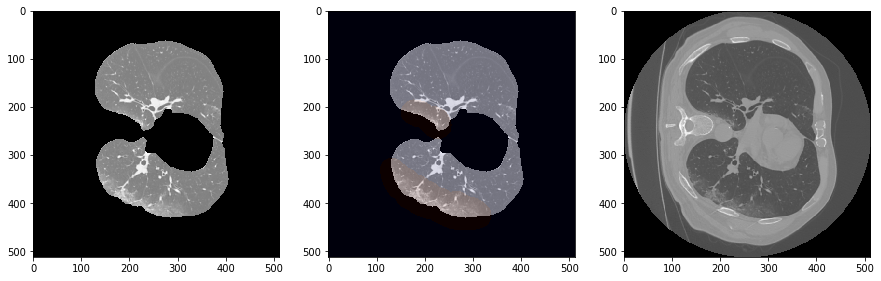

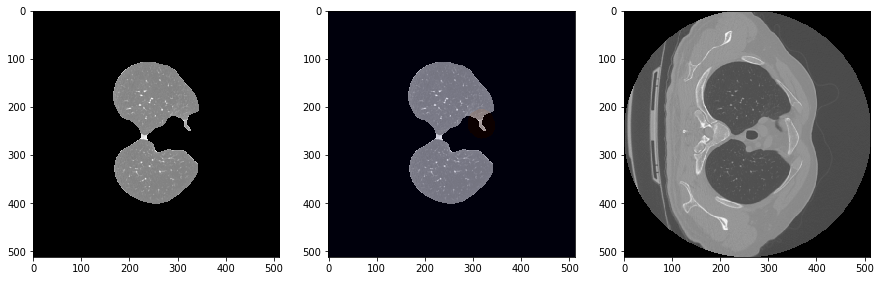

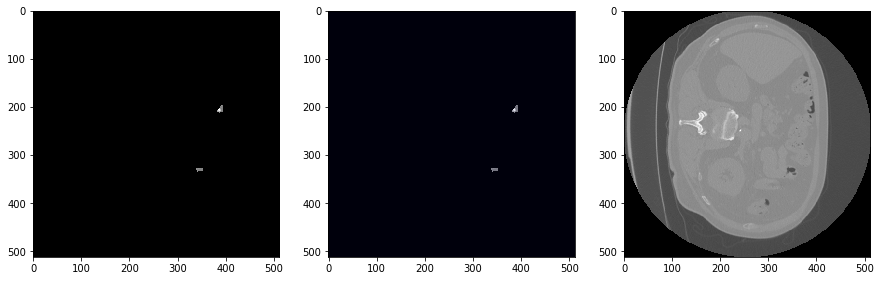

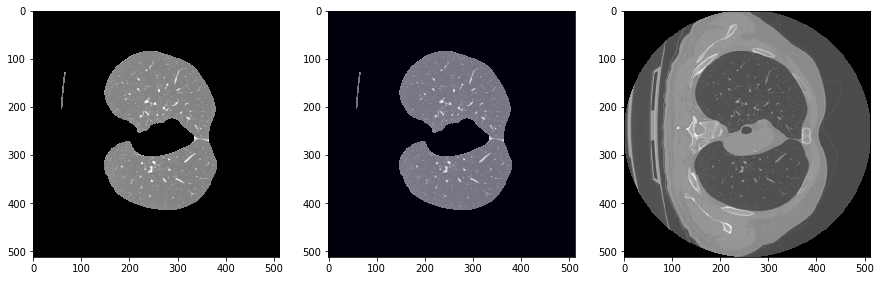

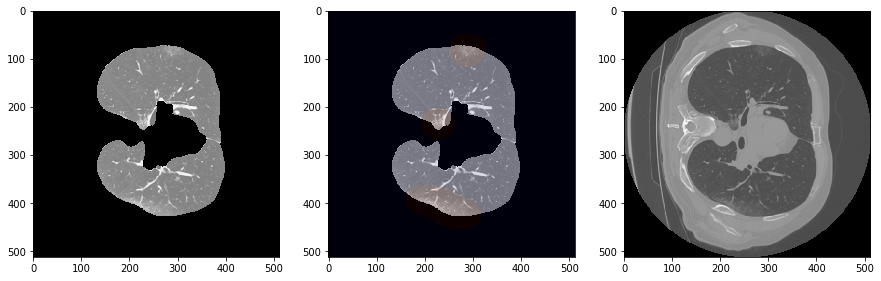

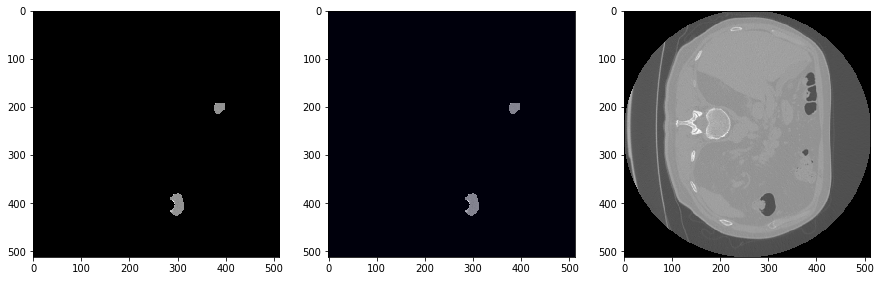

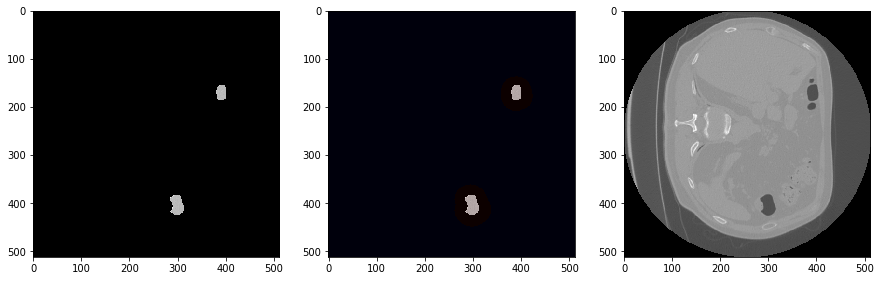

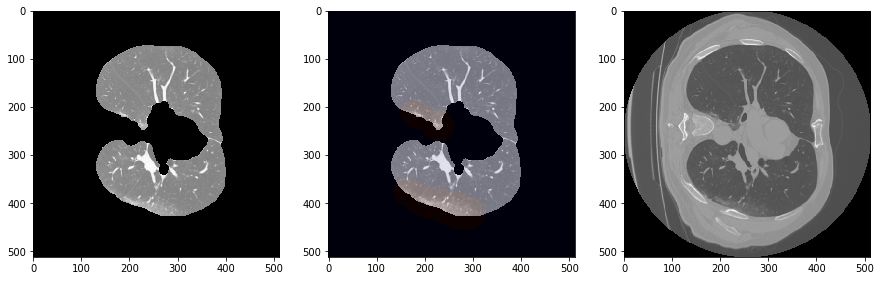

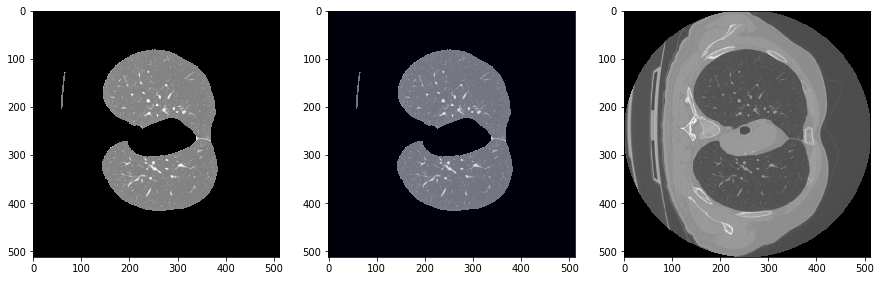

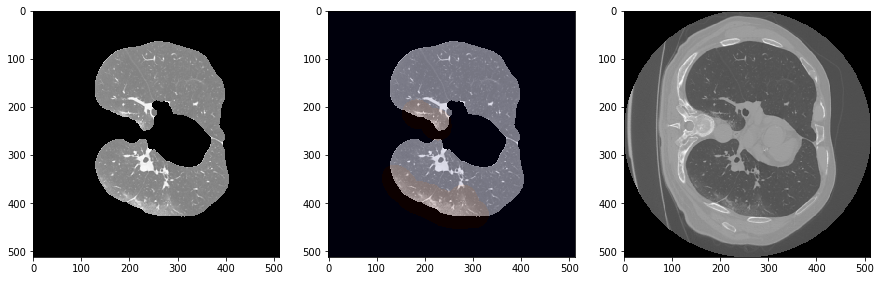

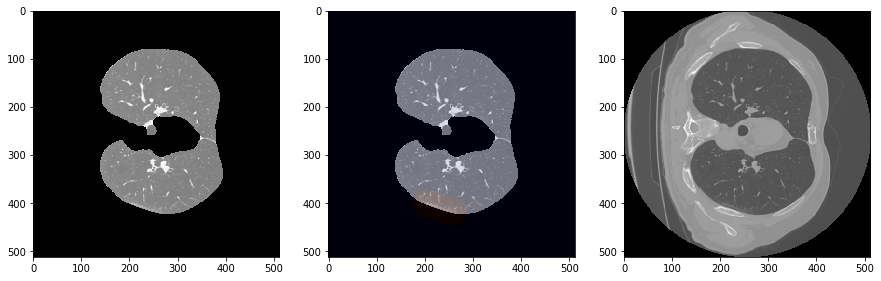

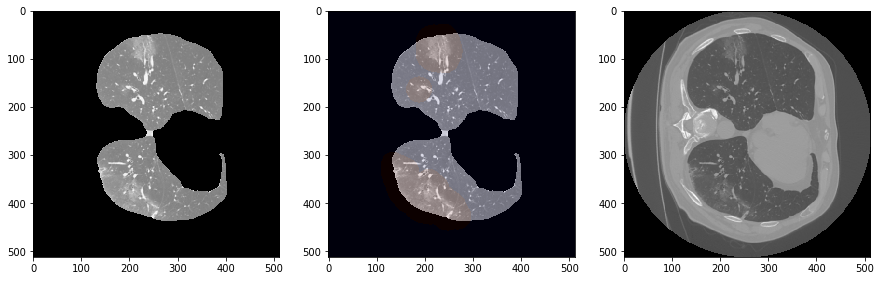

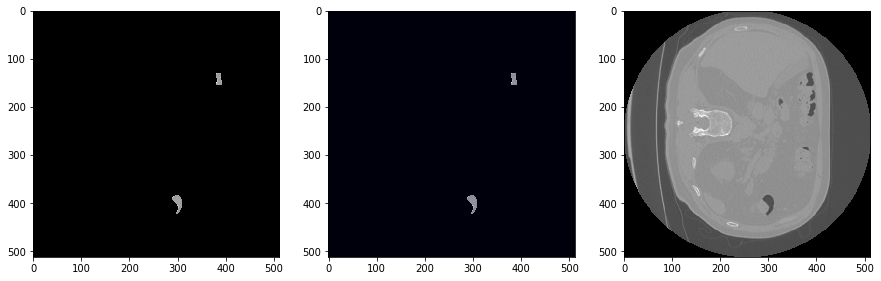

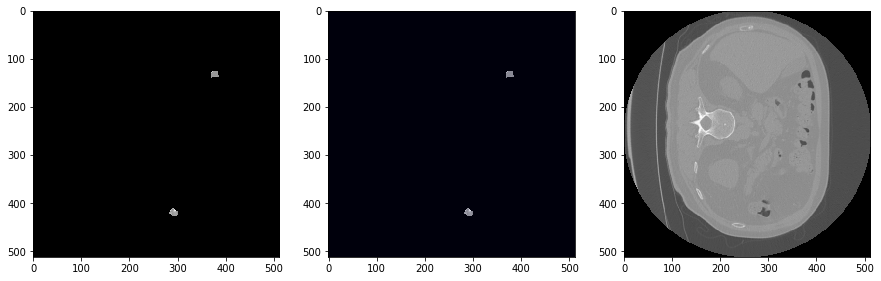

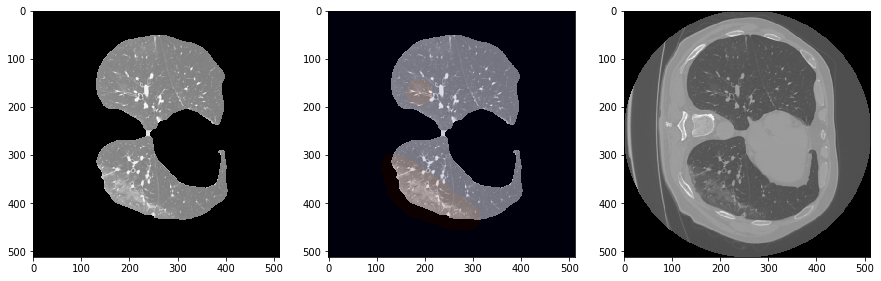

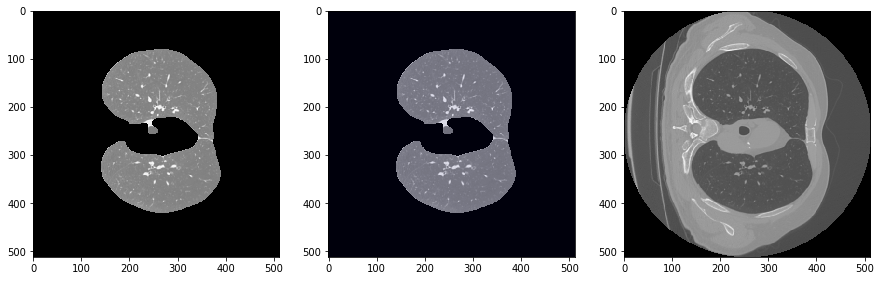

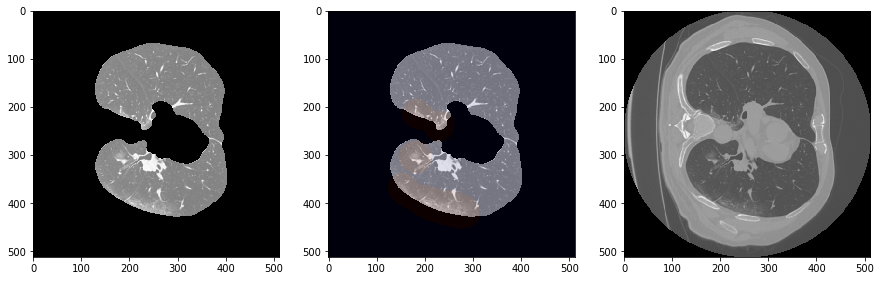

In [9]:
show_masks(2, 60)

In [61]:
def calculate_severity(i, j, radius=10):
    mypath = 'data/{}/'.format(str(i))
    i_files = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'DS_Store' not in f]
    i_files = list(set([x.split('_')[1] for x in i_files]))
    j = i_files[j]
    datafiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'study_{}'.format(j) in f]
    mypath = 'results/{}/'.format(str(i))
    maskfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'study_{}'.format(j) in f]
    areas = []
    for datafile, maskfile in zip(datafiles, maskfiles):
        im = cv2.imread('data/{}/'.format(str(i)) + datafile, cv2.IMREAD_GRAYSCALE)
        im = im > 0
        higher = np.sum(im[260:, :])
        lower = np.sum(im[:260, :])
        if type(im) == type(None) or (higher+lower) < 0.1 * (im.shape[0] * im.shape[1]):
            continue
        msk = cv2.imread('results/{}/'.format(str(i)) + maskfile, cv2.IMREAD_GRAYSCALE)
        msk = msk > 0
        msk = np.multiply(msk, im)
        msk = binary_dilation(msk, disk(radius, dtype=bool))
        areas.append(np.max((np.sum(msk[260:, :])/higher, np.sum(msk[:260, :])/lower)))
    if len(areas) < 2:
        return np.zeros(10)
#     sorted_index_array = np.argsort(areas)
#     areas_10 = np.array(areas)[sorted_index_array[-10:]]
#     areas = np.zeros(10)
#     areas[-len(areas_10):] = areas_10
#     return areas
#     print(len(areas))
    if len(areas) < 10:
        shift = (10 - len(areas)) // 2
        for _ in range(shift):
            areas.insert(0, 0)
        for _ in range(10 - len(areas)):
            areas.append(0)
    return areas[len(areas)//2 - 5 : len(areas)//2 + 5]

In [62]:
calculate_severity(1, 358)

[0,
 0.1672229998923226,
 0.09725620412443202,
 0.024485621465527616,
 0.10717546101880591,
 0.12848158131176998,
 0.1384164883432819,
 0.02979935103635521,
 0,
 0]

In [30]:
# areas = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# sorted_index_array = np.argsort(areas)
# areas_10 = np.array(areas)[sorted_index_array[-10:]]
# areas = np.zeros(10)
# areas[-len(areas_10):] = areas_10
# areas

In [31]:
%%time
calculate_severity(2, 51)

CPU times: user 1.59 s, sys: 69.3 ms, total: 1.66 s
Wall time: 1.66 s


[0.09902666102412187,
 0.0,
 0.0,
 0.06565640946342972,
 0.0,
 0.0,
 0.0,
 0.14572980469201433,
 0.04376619637201267,
 0.0,
 0.0,
 0.06802631578947368]

In [110]:
def get_true_folder_size(i):
    mypath = 'data/{}/'.format(str(i))
    i_files = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'DS_Store' not in f]
    i_files = list(set([x.split('_')[1] for x in i_files]))
    return len(i_files)

In [33]:
get_true_folder_size(0)

254

In [ ]:
plt.figure(figsize=(30, 15))
plt.subplot(131)
plt.title('Histogram of class 0')
areas_0 = [calculate_severity(0, i)[-1] for i in tqdm(range(get_true_folder_size(0)))]
# areas_0 = [calculate_severity(0, i)[1] for i in range(get_true_folder_size(0))]
plt.hist(areas_0, density = True)
plt.subplot(132)
plt.title('Histogram of class 1')
areas_1 = [calculate_severity(1, i)[-1] for i in tqdm(range(get_true_folder_size(1)))]
# areas_1 = [calculate_severity(1, i)[1] for i in range(get_true_folder_size(1))]
plt.hist(areas_1, density = True)
plt.subplot(133)
plt.title('Histogram of class 2')
areas_2 = [calculate_severity(2, i)[-1] for i in tqdm(range(get_true_folder_size(2)))]
# areas_2 = [calculate_severity(2, i)[1] for i in range(get_true_folder_size(2))]
plt.hist(areas_2, density = True)

In [16]:
import cv2
def show_masks_overlayed(j):
    shape = img_read(os.path.join(data_folders[1], file_names[1][j])).shape
    img = my_rescale(img_read(os.path.join(data_folders[1], file_names[1][j])))
    for t in np.arange(2, shape[2] - 3):
        file_path_img = 'datamasks/imgs/img_{}_{}.png'.format(j, t)
        file_path_mask = 'datamasks/masks/img_{}_{}.png'.format(j, t)
        
        im = cv2.imread(file_path_img, cv2.IMREAD_GRAYSCALE)
        if type(im) == type(None):
            continue
        plt.figure(figsize=(15, 10))
        masked = cv2.imread(file_path_mask, cv2.IMREAD_GRAYSCALE)
        plt.subplot(131)
        plt.imshow(im, 'gray', interpolation='none')
        plt.subplot(132)
        plt.imshow(im, 'gray', interpolation='none')
        plt.imshow(masked, 'jet', interpolation='none', alpha=0.1)
        plt.subplot(133)
        masked_lung = np.array(im > 0)
        plt.imshow(img[:,:,t], 'gray', interpolation='none')

In [17]:
def make_squares(j):
    shape = img_read(os.path.join(data_folders[1], file_names[1][j])).shape
    img = my_rescale(img_read(os.path.join(data_folders[1], file_names[1][j])))
    img_squares_list = []
    targets_list = []
    for t in np.arange(2, shape[2] - 3):
        file_path_img = 'datamasks/imgs/img_{}_{}.png'.format(j, t)
        file_path_mask = 'datamasks/masks/img_{}_{}.png'.format(j, t)
        
        im = cv2.imread(file_path_img, cv2.IMREAD_GRAYSCALE)
        if type(im) == type(None) or np.sum(im > 0) < 0.1 * (im.shape[0] * im.shape[1]):
            continue
        msk = cv2.imread(file_path_mask, cv2.IMREAD_GRAYSCALE)
        msk = msk > 0
        msk = np.multiply(msk, im > 0)
        msk = binary_dilation(msk, disk(1, dtype=bool))
        M = im.shape[0]//16
        N = im.shape[1]//16
        img_squares_list += [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)
                      if (im>0)[x:x+M,y:y+N].mean() > 0.2]
        targets_list += [msk[x:x+M,y:y+N].mean() for x in range(0,im.shape[0],M)
                         for y in range(0,im.shape[1],N)
                      if (im>0)[x:x+M,y:y+N].mean() > 0.2]
    return img_squares_list, targets_list

In [46]:
_, targets = make_squares(0)

In [15]:
# def make_squares(i, j):
#     mypath = 'data/{}/'.format(str(i))
#     i_files = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'DS_Store' not in f]
#     i_files = list(set([x.split('_')[1] for x in i_files]))
#     j = i_files[j]
#     datafiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'study_{}'.format(j) in f]
#     mypath = 'results/{}/'.format(str(i))
#     maskfiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'study_{}'.format(j) in f]
#     img_squares_list = []
#     targets_list = []
#     for datafile, maskfile in zip(datafiles, maskfiles):
#         im = cv2.imread('data/{}/'.format(str(i)) + datafile, cv2.IMREAD_GRAYSCALE)
#         if type(im) == type(None) or np.sum(im > 0) < 0.125 * (im.shape[0] * im.shape[1]):
#             continue
#         msk = cv2.imread('results/{}/'.format(str(i)) + maskfile, cv2.IMREAD_GRAYSCALE)
#         msk = msk > 0
#         msk = np.multiply(msk, im > 0)
#         msk = binary_dilation(msk, disk(1, dtype=bool))
#         M = im.shape[0]//16
#         N = im.shape[1]//16
#         img_squares_list += [im[x:x+M,y:y+N] for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)
#                       if (im>0)[x:x+M,y:y+N].mean() > 0.5]
#         targets_list += [msk[x:x+M,y:y+N].mean()/(im>0)[x:x+M,y:y+N].mean() for x in range(0,im.shape[0],M) for y in range(0,im.shape[1],N)
#                       if (im>0)[x:x+M,y:y+N].mean() > 0.5]
#     return img_squares_list, targets_list

In [47]:
%%time
squares, targets = make_squares(91)

CPU times: user 1.47 s, sys: 108 ms, total: 1.58 s
Wall time: 1.59 s


In [17]:
# i = 2
# j = 90
# mypath = 'data/{}/'.format(str(i))
# i_files = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'DS_Store' not in f]
# i_files = list(set([x.split('_')[1] for x in i_files]))
# j = i_files[j]
# datafiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'study_{}'.format(j) in f]
# im = cv2.imread('data/{}/'.format(str(i)) + datafiles[0], cv2.IMREAD_GRAYSCALE)

In [20]:
calculate_severity(0, 15)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.03300685, 0.06271124])

In [63]:
# X = np.zeros((get_true_folder_size(0) + get_true_folder_size(1) + get_true_folder_size(2), 10))
# y = np.zeros(get_true_folder_size(0) + get_true_folder_size(1) + get_true_folder_size(2))
# for i in tqdm(range(get_true_folder_size(0))):
#     X[i] = calculate_severity(0, i)
#     y[i] = 0
for i in tqdm(range(get_true_folder_size(1))):
    X[get_true_folder_size(0) + i] = calculate_severity(1, i)
    y[get_true_folder_size(0) + i] = 1
for i in tqdm(range(get_true_folder_size(2))):
    X[get_true_folder_size(0) + get_true_folder_size(1) + i] = calculate_severity(2, i)
    y[get_true_folder_size(0) + get_true_folder_size(1) + i] = 2


100%|██████████| 172/172 [09:53<00:00,  3.45s/it]


In [45]:
calculate_severity(1, 358)

([0],
 [0,
  0.1672229998923226,
  0.09725620412443202,
  0.024485621465527616,
  0.10717546101880591,
  0.12848158131176998,
  0.1384164883432819,
  0.02979935103635521,
  0])

In [70]:
np.save('X_unet.npy', X)

### Top10 features

In [64]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [69]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMRegressor
scores = []
for i in tqdm(range(1000)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)
    rmos = RandomOverSampler(random_state=2021)
    X_train_, y_train_ = rmos.fit_resample(X_train, y_train)
    clf = LogisticRegression(penalty='l1', solver='liblinear')
    clf.fit(X_train_, y_train_)
    rmos = RandomOverSampler(random_state=2021)
    X_test_, y_test_ = rmos.fit_resample(X_test, y_test)
    scores.append(clf.score(X_test_, y_test_))
np.array(scores).mean()

100%|██████████| 1000/1000 [00:07<00:00, 139.25it/s]


0.6368941949760976

In [66]:
# from sklearn.linear_model import LogisticRegression, Lasso
# scores = []
# for i in tqdm(range(1000)):
#     X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)
#     rmos = RandomUnderSampler(random_state=2021)
#     X_train_, y_train_ = rmos.fit_resample(X_train, y_train)
#     clf = LogisticRegression(penalty='l1', solver='liblinear')
#     clf.fit(X_train_, y_train_)
#     rmos = RandomOverSampler(random_state=2021)
#     X_test_, y_test_ = rmos.fit_resample(X_test, y_test)
#     scores.append(clf.score(X_test_, y_test_))
# np.array(scores).mean()

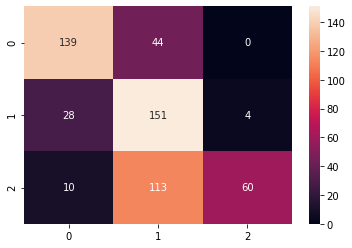

In [175]:
cm = confusion_matrix(y_test_, clf.predict(X_test_))
sns.heatmap(cm, annot=True,fmt='g')
plt.show()

In [176]:
np.trace(cm)/np.sum(cm)

0.6375227686703097

In [190]:
clf.coef_

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -5.54401223,  0.        , -6.95244357, -2.8933687 ,  0.        ],
       [ 0.        , -2.43616563,  0.        ,  0.        ,  0.        ,
         0.        ,  1.52478498,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  2.00764252,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.21961557,  3.49626635,  0.        ]])

In [18]:
# squares_0 = []
# targets_0 = []
# for i in tqdm(range(get_true_folder_size(0))):
#     squares, targets = make_squares(0, i)
#     squares_0 += squares
#     targets_0 += targets
# squares_0 = np.stack(squares_0)
# targets_0 = np.array(targets_0)
# with open('squares/squares_0.npy', 'wb') as f:
#     np.save(f, squares_0)
# with open('squares/targets_0.npy', 'wb') as f:
#     np.save(f, targets_0)

squares_1 = []
targets_1 = []
for i in tqdm(range(50)):
    squares, targets = make_squares(i)
    squares_1 += squares
    targets_1 += targets
squares_1 = np.stack(squares_1)
targets_1 = np.array(targets_1)
with open('squares/squares.npy', 'wb') as f:
    np.save(f, squares_1)
with open('squares/targets.npy', 'wb') as f:
    np.save(f, targets_1)
    
# squares_2 = []
# targets_2 = []
# for i in tqdm(range(get_true_folder_size(2))):
#     squares, targets = make_squares(2, i)
#     squares_2 += squares
#     targets_2 += targets
# squares_2 = np.stack(squares_2)
# targets_2 = np.array(targets_2)
# with open('squares/squares_2.npy', 'wb') as f:
#     np.save(f, squares_2)
# with open('squares/targets_2.npy', 'wb') as f:
#     np.save(f, targets_2)

100%|██████████| 50/50 [01:28<00:00,  1.76s/it]


In [21]:
# with open('squares/squares_0.npy', 'rb') as f:
#     squares_0 = np.load(f)
# with open('squares/targets_0.npy', 'rb') as f:
#     targets_0 = np.load(f)
# with open('squares/squares_1.npy', 'rb') as f:
#     squares_1 = np.load(f)
# with open('squares/targets_1.npy', 'rb') as f:
#     targets_1 = np.load(f)
# with open('squares/squares_2.npy', 'rb') as f:
#     squares_2 = np.load(f)
# with open('squares/targets_2.npy', 'rb') as f:
#     targets_2 = np.load(f)

In [22]:
# with open('squares/squares.npy', 'wb') as f:
#     np.save(f, np.concatenate((squares_0, squares_1, squares_2)))

# with open('squares/targets.npy', 'wb') as f:
#     np.save(f, np.concatenate((targets_0, targets_1, targets_2)))

(array([3.51026522, 1.81711843, 1.6931468 , 1.24311279, 1.24990576,
        1.21763917, 1.17857962, 1.09536578, 0.97139415, 0.99856601,
        0.97139415, 0.88308559, 0.89497328, 0.89497328, 0.76930341,
        0.81685417, 0.78968231, 0.84062955, 0.76251044, 0.75741572,
        0.7115632 , 0.71326144, 0.69967551, 0.77100165, 0.73024385,
        0.63174585, 0.6911843 , 0.64703002, 0.64872826, 0.65552123,
        0.70986496, 0.60797046, 0.6504265 , 0.65382299, 0.63853881,
        0.6215564 , 0.6504265 , 0.60627222, 0.60797046, 0.68608957,
        0.59608277, 0.69967551, 0.63684057, 0.61985816, 0.7404333 ,
        0.73364034, 0.8711979 , 1.05970271, 1.31104245, 6.09159233]),
 array([9.76562500e-04, 2.09570313e-02, 4.09375000e-02, 6.09179688e-02,
        8.08984375e-02, 1.00878906e-01, 1.20859375e-01, 1.40839844e-01,
        1.60820313e-01, 1.80800781e-01, 2.00781250e-01, 2.20761719e-01,
        2.40742188e-01, 2.60722656e-01, 2.80703125e-01, 3.00683594e-01,
        3.20664063e-01, 3.4064

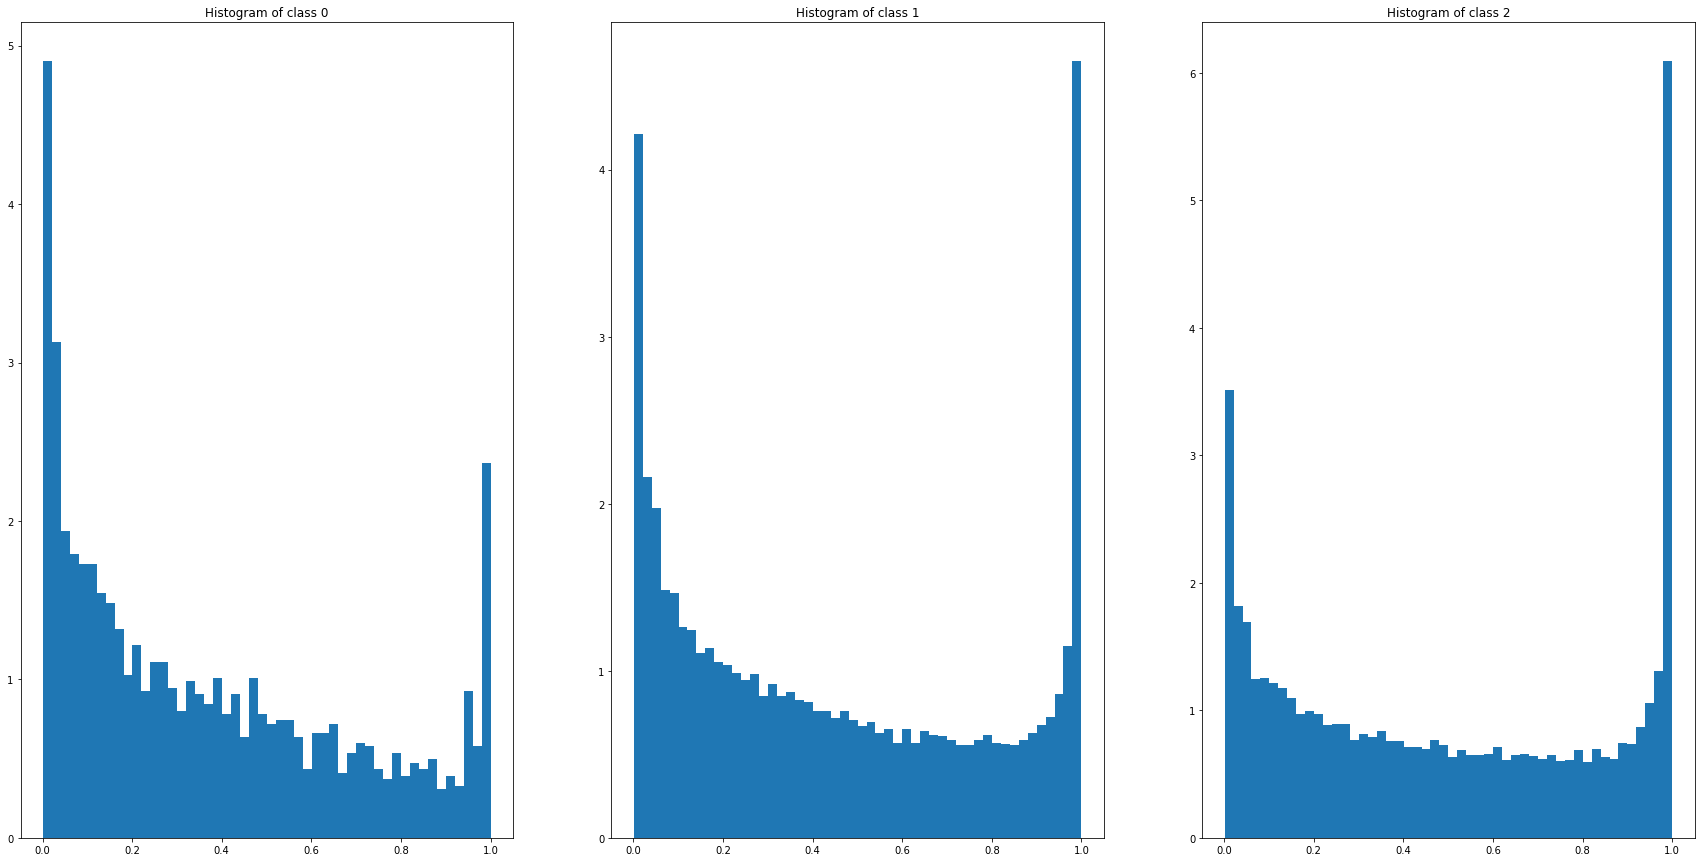

In [23]:
%matplotlib inline
plt.figure(figsize=(30, 15))
plt.subplot(131)
plt.title('Histogram of class 0')
plt.hist(targets_0[targets_0 != 0], bins=50, density = True)
plt.subplot(132)
plt.title('Histogram of class 1')
plt.hist(targets_1[targets_1 != 0], bins=50, density = True)
plt.subplot(133)
plt.title('Histogram of class 2')
plt.hist(targets_2[targets_2 != 0], bins=50, density = True)

# LSF + H0 + H1

In [54]:
from persim import plot_diagrams
import matplotlib.pyplot as plt
from ripser import ripser, lower_star_img
import cripser as cr
import time
from os import listdir
from os.path import isfile, join
import cv2
import numpy as np
import gudhi.representations as tda
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler

In [55]:
def plot_img_and_dgm_ripser(img, name=''):
    dgm = lower_star_img(img)
    print('Image shape', img.shape)
    print('Diagram shape', dgm.shape)
    plt.figure(figsize=(6, 3))
    plt.subplot(121)
    plt.imshow(img)
    plt.colorbar()
    plt.title('Image {}'.format(name))
    plt.subplot(122)
    plot_diagrams(dgm)
    plt.title('0-D persistence diagrams')
    plt.tight_layout()
    plt.show()
    return None

In [56]:
def get_image(i, j, t):
    mypath = 'data/{}/'.format(str(i))
    i_files = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'DS_Store' not in f]
    i_files = list(set([x.split('_')[1] for x in i_files]))
    j = i_files[j]
    datafiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'study_{}'.format(j) in f]
    features = []
    im = cv2.imread('data/{}/'.format(str(i)) + datafiles[t], cv2.IMREAD_GRAYSCALE)
    return im

In [15]:
img = get_image(0, 10, 20)/255.0

In [34]:
dgm = lower_star_img(img)

In [16]:
# compute PH for the V-construction with the python wrapper (takes time)
start = time.time()
pd = cr.computePH(img)
print ("elapsed_time:{} sec".format(time.time() - start))
print("Betti numbers: ",[np.sum(pd[:,0] == i) for i in range(3)])

elapsed_time:0.1238558292388916 sec
Betti numbers:  [1767, 1301, 0]


Image shape (512, 512)
Diagram shape (1350, 2)


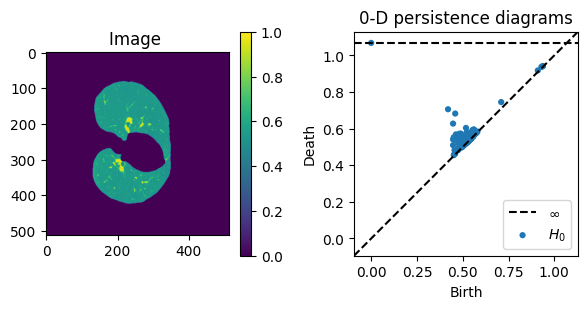

In [33]:
plot_img_and_dgm_ripser(img)

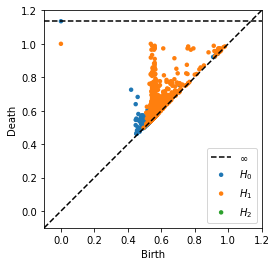

In [27]:
## plot persistent diagram using persim
%matplotlib inline
import persim
pds = [pd[pd[:,0] == i] for i in range(3)]
persim.plot_diagrams([p[:,1:3] for p in pds])

In [40]:
dgm.shape, pds[0][:, 1:3].shape, pds[1][:, 1:3].shape, pds[2][:, 1:3].shape,

((1350, 2), (1767, 2), (1301, 2), (0, 2))

In [49]:
# pipe = Pipeline([("TDA",       tda.BettiCurve()),
#                  ("Estimator", lgb(max_depth=2))])

In [68]:
def clean_dgm(dgm):
    whereinf = np.isfinite(dgm)
    dgm[~whereinf] = 1
    dgm = np.nan_to_num(dgm)
    return dgm
def clean_dgms(dgms):
    for i in tqdm(range(len(dgms))):
        array = dgms[i]
        whereinf = np.isfinite(array)
        array[~whereinf] = 1
        array = np.nan_to_num(array)
        dgms[i] = array
    return dgms

In [58]:
betti = tda.BettiCurve()
betti.fit_transform([clean_dgm(dgm), clean_dgm(dgm)])

array([[  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,   2.,
          2.,   7.,  12.,  18.,  20.,  42.,  73., 170., 412., 444., 144.,
         76.,  31.,  21.,   7.,   6.,   4.,   4.,   4.,   3.,   3.,   3.,
          3.,   3.,   2.,   2.,   1.,   2.,   2.,   2.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   3.,   1.,   1.,   1.,   1.,   1.,
          0.],
       [  1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   2.,   2.,
          2.,   7.,  12

In [86]:
# feats : LSF, H_0, H_1
# targets : mask_area

def make_feats_targets():
    feats_list = [[], [], []]
    targets_list = []
    for j in tqdm(range(50)):
        shape = img_read(os.path.join(data_folders[1], file_names[1][j])).shape
        img = my_rescale(img_read(os.path.join(data_folders[1], file_names[1][j])))
        for t in np.arange(2, shape[2] - 3):
            file_path_img = 'datamasks/imgs/img_{}_{}.png'.format(j, t)
            file_path_mask = 'datamasks/masks/img_{}_{}.png'.format(j, t)

            im = cv2.imread(file_path_img, cv2.IMREAD_GRAYSCALE)
            
            if type(im) == type(None) or np.sum(im > 0) < 0.1 * (im.shape[0] * im.shape[1]):
                continue
            im_high = im[:256, :]
            im_low = im[256:, :]
            msk = cv2.imread(file_path_mask, cv2.IMREAD_GRAYSCALE)
            msk = msk > 0
            msk = np.multiply(msk, im > 0)
            msk = binary_dilation(msk, disk(5, dtype=bool))
            msk_high = msk[:256, :]
            msk_low = msk[256:, :]
            pd = cr.computePH(im_low/255.0)
            pds = [pd[pd[:,0] == i][:, 1:3] for i in range(3)]
            dgm = lower_star_img(im_low/255.0)
            feats_list[0].append(dgm)
            feats_list[1].append(pds[0])
            feats_list[2].append(pds[1])
            targets_list.append(np.sum(msk_low>0)/np.sum(im_low>0))
            pd = cr.computePH(im_high/255.0)
            pds = [pd[pd[:,0] == i][:, 1:3] for i in range(3)]
            dgm = lower_star_img(im_high/255.0)
            feats_list[0].append(dgm)
            feats_list[1].append(pds[0])
            feats_list[2].append(pds[1])
            targets_list.append(np.sum(msk_high>0)/np.sum(im_high>0))
    return feats_list, targets_list

In [87]:
feats_raw, targets = make_feats_targets()

100%|██████████| 50/50 [08:20<00:00, 10.02s/it]


In [88]:
len(targets)

1322

In [89]:
betti_0 = tda.BettiCurve(resolution=100)
cleaned_dgms = clean_dgms(feats_raw[0])
feats_0 = betti_0.fit_transform(cleaned_dgms)
feats_0.shape

100%|██████████| 1322/1322 [00:00<00:00, 22184.09it/s]


(1322, 100)

In [96]:
betti_0.transform([cleaned_dgms[0]]).shape

(1, 100)

In [91]:
betti_1 = tda.BettiCurve(resolution=100)
cleaned_dgms = clean_dgms(feats_raw[1])
feats_1 = betti_1.fit_transform(cleaned_dgms)
feats_1.shape

100%|██████████| 1322/1322 [00:00<00:00, 7513.50it/s]
/Users/ahmadsumekenov/Library/Caches/pypoetry/virtualenvs/diploma-GCnEs1M7-py3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


(1322, 100)

In [92]:
betti_2 = tda.BettiCurve(resolution=100)
cleaned_dgms = clean_dgms(feats_raw[2])
feats_2 = betti_2.fit_transform(cleaned_dgms)
feats_2.shape

100%|██████████| 1322/1322 [00:00<00:00, 8339.76it/s]


(1322, 100)

In [93]:
feats = np.concatenate([feats_0, feats_1, feats_2], axis=1)
feats.shape

(1322, 300)

In [118]:
# from sklearn.linear_model import LogisticRegression, SGDClassifier
# from sklearn.svm import LinearSVC
from lightgbm import LGBMRegressor as lgbregressor

scores = []
for i in tqdm(range(1000)):
    X_train, X_test, y_train, y_test = train_test_split(feats, targets, shuffle=True)
#     clf = lgb(max_depth=1)
    clf = lgbregressor(max_depth=2)
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    clf.fit(X_train_scaled, y_train)
    scores.append(clf.score(scaler.transform(X_test), y_test))
np.array(scores).mean()

In [120]:
lgbclf = lgbregressor(max_depth=2)
scaler = StandardScaler()
scaler.fit(feats)
X_train_scaled = scaler.transform(feats)
lgbclf.fit(X_train_scaled, targets)

LGBMRegressor(max_depth=2)

In [121]:
def relu(x):
    return x * (x > 0)
def get_features(i, j):
    mypath = 'data/{}/'.format(str(i))
    i_files = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'DS_Store' not in f]
    i_files = list(set([x.split('_')[1] for x in i_files]))
    j = i_files[j]
    datafiles = [f for f in listdir(mypath) if isfile(join(mypath, f)) and 'study_{}'.format(j) in f]
    features = []
    for datafile in datafiles:
        im = cv2.imread('data/{}/'.format(str(i)) + datafile, cv2.IMREAD_GRAYSCALE)
        if type(im) == type(None) or np.sum(im > 0) < 0.125 * (im.shape[0] * im.shape[1]):
            continue
        im_high = im[:256, :]
        im_low = im[256:, :]
        pd = cr.computePH(im_low/255.0)
        pds = [pd[pd[:,0] == i][:, 1:3] for i in range(3)]
        dgm_low = lower_star_img(im_low/255.0)
        pd_0_low = pds[0]
        pd_1_low = pds[1]
        pd = cr.computePH(im_high/255.0)
        pds = [pd[pd[:,0] == i][:, 1:3] for i in range(3)]
        dgm_high = lower_star_img(im_high/255.0)
        pd_0_high = pds[0]
        pd_1_high = pds[1]
        low_feat = np.concatenate([betti_0.transform([dgm_low]), 
                                   betti_1.transform([pd_0_low]),
                                   betti_2.transform([pd_1_low])], axis=1)
        high_feat = np.concatenate([betti_0.transform([dgm_low]), 
                                   betti_1.transform([pd_0_low]),
                                   betti_2.transform([pd_1_low])], axis=1)
        features.append(max(lgbclf.predict(scaler.transform(low_feat.reshape(1, -1)))[0],
                            lgbclf.predict(scaler.transform(high_feat.reshape(1, -1)))[0]))
        
    if len(features) == 0:
        return np.zeros(10)
    sorted_index_array = np.argsort(features)
    features_10 = np.array(features)[sorted_index_array[-10:]]
    features = np.zeros(10)
    features[-len(features_10):] = features_10
    return features

In [124]:
%%time
get_features(0, 23)

CPU times: user 48.2 s, sys: 4.99 s, total: 53.2 s
Wall time: 14.9 s


array([0.02105617, 0.02397953, 0.02433442, 0.02798454, 0.02877342,
       0.03952391, 0.0410345 , 0.04139129, 0.0653739 , 0.073413  ])

In [126]:
%%time
get_features(2, 39)

CPU times: user 54 s, sys: 5.54 s, total: 59.6 s
Wall time: 16.8 s


array([0.03964105, 0.04313401, 0.04553339, 0.04637152, 0.05002682,
       0.05675954, 0.05942299, 0.06075846, 0.06193166, 0.13113354])

In [111]:
X = np.zeros((get_true_folder_size(0) + get_true_folder_size(1) + get_true_folder_size(2), 10))
y = np.zeros(get_true_folder_size(0) + get_true_folder_size(1) + get_true_folder_size(2))
for i in tqdm(range(get_true_folder_size(0))):
    X[i] = get_features(0, i)
    y[i] = 0
for i in tqdm(range(get_true_folder_size(1))):
    X[get_true_folder_size(0) + i] = get_features(1, i)
    y[get_true_folder_size(0) + i] = 1
for i in tqdm(range(get_true_folder_size(2))):
    X[get_true_folder_size(0) + get_true_folder_size(1) + i] = get_features(2, i)
    y[get_true_folder_size(0) + get_true_folder_size(1) + i] = 2

100%|██████████| 172/172 [30:44<00:00, 10.72s/it]


In [113]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix
import seaborn as sns

from lightgbm import LGBMClassifier as lgb

from sklearn.linear_model import LogisticRegression
scores = []
for i in tqdm(range(1000)):
    X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True)
    rmos = RandomUnderSampler(random_state=2021)
    X_train_, y_train_ = rmos.fit_resample(X_train, y_train)
#     clf = LogisticRegression(penalty='l1', solver='liblinear')
    clf = lgb(max_depth=2)
    clf.fit(X_train_, y_train_)
    rmos = RandomOverSampler(random_state=2021)
    X_test_, y_test_ = rmos.fit_resample(X_test, y_test)
    scores.append(clf.score(X_test_, y_test_))
np.array(scores).mean()

100%|██████████| 1000/1000 [00:24<00:00, 41.28it/s]


0.5117518169093852

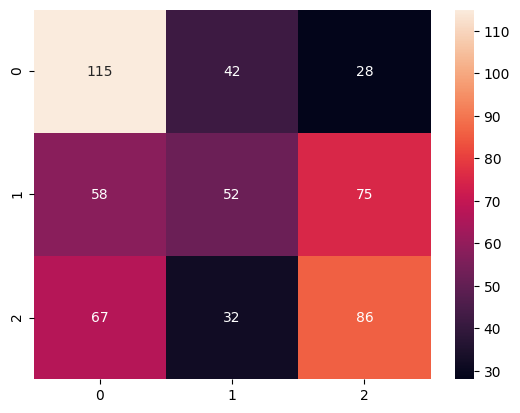

In [114]:
cm = confusion_matrix(y_test_, clf.predict(X_test_))
sns.heatmap(cm, annot=True,fmt='g')
plt.show()